# Comparison of two-canyon runs

* All experiments have 3 runs to get a mean curve (except aug01).
* Parameters can be found on google drive sheet lab_speadsheets/exp_list

Using calibration from May 2nd 2019 (Most linear response) but also trying the one on the 6th to check how it affects density change in the canyon heads.


In [12]:
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.polynomial import polynomial as P
import os
import pandas as pd
#import seaborn as sns
import scipy.io as sio
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('/ocean/kramosmu/MultipleCanyons/lab/Conduino/scripts')
import profiler_tools as ptools
import conduino_tools as ctools


In [13]:
sns.set_style('whitegrid')
sns.set_context('notebook')

In [14]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [15]:
def plot_uprofile(ax, col='0.8'):
    ax.axvline(21.0, color=col, linestyle=':')
    ax.axvline(71.0, color=col, linestyle=':')
        
def plot_forcing(ax, file, f0, f1, f2, t0, t1):
    '''ax: axes to plot figure on
       file: experiment file to extract time
       f0: Angular velocity of the table during spin up
       f1: f at max forcing
       f2: f to avoid spin down
       t0: time to get to f1
       t1: time to get to f2'''
    mat = sio.loadmat(file, squeeze_me=True)
    time = mat['time']
    t2 = np.round(np.max(time),2) # s

    ax0.text(0.3,0.3,r'$\Delta f_1=$%1.2f rad/s, $\Delta t_1=$%1.1f s' %((f1-f0),t0), transform=ax0.transAxes)
    ax0.text(0.5,0.7,r'$\Delta f_2=$%1.2f rad/s, $\Delta t_2=$%1.1f s' %((f2-f1),(t1-t0)), transform=ax0.transAxes)

    ax0.plot([0,t0,t1,t2],[f0,f1,f2,f2], 'g-')
    ax0.set_ylabel('f table / rad s$^{-1}$')
    ax0.set_xlabel('time / s')

In [16]:
# Dictionaries:

A01 = {"date": "31Jul19",
       "Nsb": 1.23 ,
       "Nshelf": 1.5,
       "fo": 0.5 ,
       "U":0.5 ,
       "run_num": 3,''
       "dir": '../experiments/exp_31jul19/',
       "run_files":['06_experiment1.mat','09_experiment2.mat','12_experiment3.mat'],
       "color":'mediumseagreen',
       }
A02 = {"date": "01Aug19",
       "Nsb": 1.03 ,
       "Nshelf": 1.02,
       "fo": 0.5 ,
       "U":0.5 ,
       "run_num": 2,''
       "dir": '../experiments/exp_01aug19/',
       "run_files":['06_experiment1.mat','09_experiment2.mat'],
       "color":'darkcyan',
       }
A03 = {"date": "05Aug19",
       "Nsb": 0.92 ,
       "Nshelf": 1.2,
       "fo": 0.5 ,
       "U":0.5 ,
       "run_num": 3,''
       "dir": '../experiments/exp_05aug19/',
       "run_files":['05_experiment1.mat','07_experiment2.mat','09_experiment3.mat'],
       "color":'darkslateblue'
       }

A04 = {"date": "07Aug19",
       "Nsb": 1.46 ,
       "Nshelf": 1.47,
       "fo": 0.5 ,
       "U":0.5 ,
       "run_num": 4,
       "dir": '../experiments/exp_07aug19/',
       "run_files":['04_experiment1.mat','07_experiment2.mat','09_experiment3.mat', '10_experiment4.mat'],
       "color":'darkmagenta'
       }

A05 = {"date": "08Aug19",
       "Nsb": 1.46 ,
       "Nshelf": 1.45,
       "fo": 0.5 ,
       "U":0.5 ,
       "run_num": 2,
       "dir": '../experiments/exp_08aug19/',
       "run_files":['04_experiment1.mat','09_experiment3.mat'],#'07_experiment2.mat'
       "color":'plum'
       }


In [17]:
exp_dicts = [A01,A03,A02,A04,A05]
exp_num = len(exp_dicts) # number of experiment dictionaries

colors = ['teal','darkorange','yellowgreen', 'tan']

### READINGS

../experiments/exp_31jul19/06_experiment1.mat
../experiments/exp_31jul19/09_experiment2.mat
../experiments/exp_31jul19/12_experiment3.mat
../experiments/exp_05aug19/05_experiment1.mat
../experiments/exp_05aug19/07_experiment2.mat
../experiments/exp_05aug19/09_experiment3.mat
../experiments/exp_01aug19/06_experiment1.mat
../experiments/exp_01aug19/09_experiment2.mat
../experiments/exp_07aug19/04_experiment1.mat
../experiments/exp_07aug19/07_experiment2.mat
../experiments/exp_07aug19/09_experiment3.mat
../experiments/exp_07aug19/10_experiment4.mat
../experiments/exp_08aug19/04_experiment1.mat
../experiments/exp_08aug19/09_experiment3.mat


Text(0.5,0,'time / s')

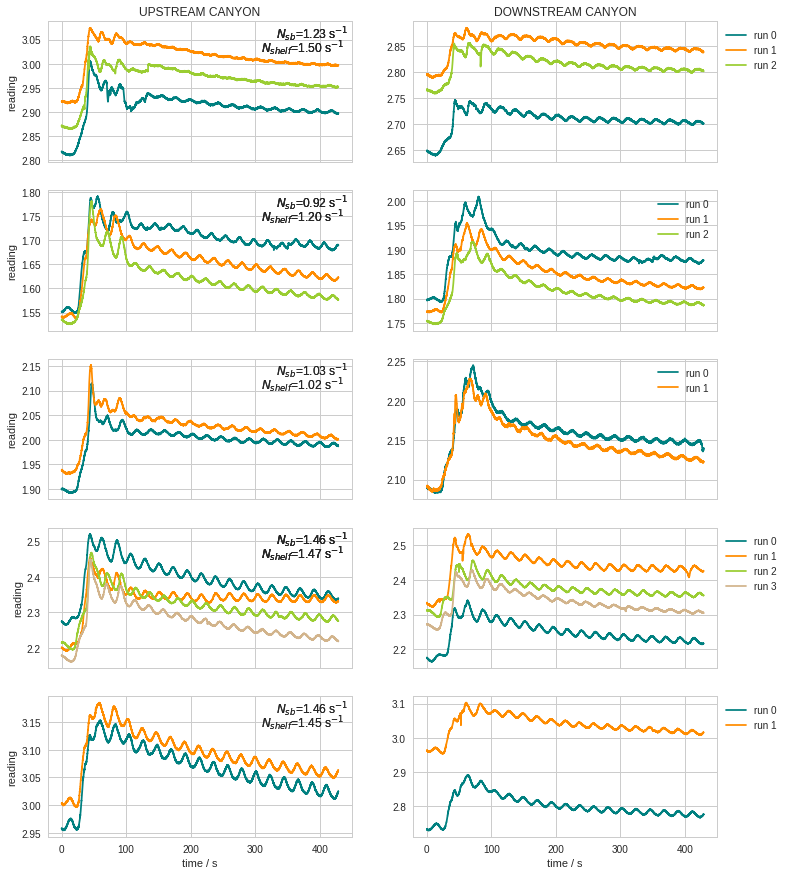

In [18]:
fig, ax = plt.subplots(exp_num, 2, figsize=(12,exp_num*3), sharex=True)

ax[0,0].set_title('UPSTREAM CANYON')
ax[0,1].set_title('DOWNSTREAM CANYON')

for exp, kk in zip(exp_dicts, range(exp_num)):
    
    for ii, col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        print(filepath)
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        time = mat['time']
        ax[kk,0].plot(time,P1,'-',color=col, label='run %d' %ii)
        ax[kk,1].plot(time,P2,'-',color=col, label='run %d' %ii)
        ax[kk,0].text(0.75,0.88,'$N_{sb}$=%1.2f s$^{-1}$' %exp["Nsb"], transform=ax[kk,0].transAxes)
        ax[kk,0].text(0.7,0.78,'$N_{shelf}$=%1.2f s$^{-1}$' %exp["Nshelf"], transform=ax[kk,0].transAxes)
       
    ax[kk,0].set_ylabel('reading')
    ax[kk,1].legend(bbox_to_anchor=(1,1))

ax[kk,0].set_xlabel('time / s')
ax[kk,1].set_xlabel('time / s')


### Density change from initial value

Using calibration May 2nd:

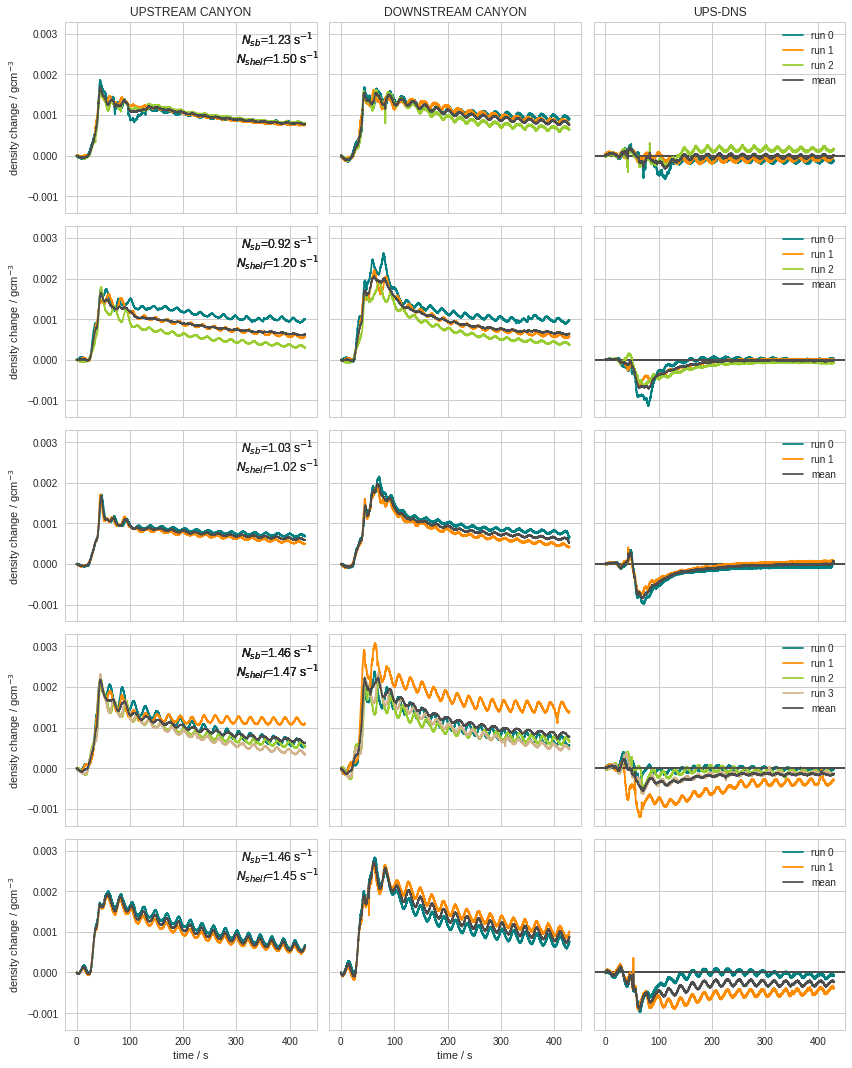

In [19]:
fig, ax = plt.subplots(exp_num, 3, figsize=(12,exp_num*3), sharey=True, sharex=True)

ax[0,0].set_title('UPSTREAM CANYON')
ax[0,1].set_title('DOWNSTREAM CANYON')
ax[0,2].set_title('UPS-DNS')

for exp, kk in zip(exp_dicts, range(exp_num)):
    avg1 = np.zeros_like(time)
    avg2 = np.zeros_like(time)
    avg3 = np.zeros_like(time)
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        time = mat['time']
        dens1 = ctools.densANK1_02May19(P1)
        dens2 = ctools.densANK2_02May19(P2)
        ax[kk,0].plot(time, dens1-dens1[0],'-',color=col, label='run %d' %ii)
        ax[kk,1].plot(time, dens2-dens2[0],'-',color=col, label='run %d' %ii)
        ax[kk,2].axhline(0, color='0.3')
        ax[kk,2].plot(time, (dens1-dens1[0])-(dens2-dens2[0]),'-',color=col, label='run %d' %ii)
        ax[kk,0].text(0.70,0.88,'$N_{sb}$=%1.2f s$^{-1}$' %exp["Nsb"], transform=ax[kk,0].transAxes)
        ax[kk,0].text(0.68,0.78,'$N_{shelf}$=%1.2f s$^{-1}$' %exp["Nshelf"], transform=ax[kk,0].transAxes)
        avg1 = avg1+(dens1-dens1[0])
        avg2 = avg2+(dens2-dens2[0])
        avg3 = avg3+((dens1-dens1[0])-(dens2-dens2[0]))
    ax[kk,0].plot(time, avg1/(len(exp['run_files'])),'-',color='0.3', label='mean')
    ax[kk,1].plot(time, avg2/(len(exp['run_files'])),'-',color='0.3', label='mean')
    ax[kk,2].plot(time, avg3/(len(exp['run_files'])),'-',color='0.3', label='mean')    
    ax[kk,0].set_ylabel('density change / gcm$^{-3}$')
    ax[kk,2].legend(bbox_to_anchor=(1,1))

ax[kk,0].set_xlabel('time / s')
ax[kk,1].set_xlabel('time / s')
plt.tight_layout()

Using calibration July 6th - Density in upstream probe is larger than when using May 2nd calibration while downstream canyon density is lower than using May 2nd calibration. 

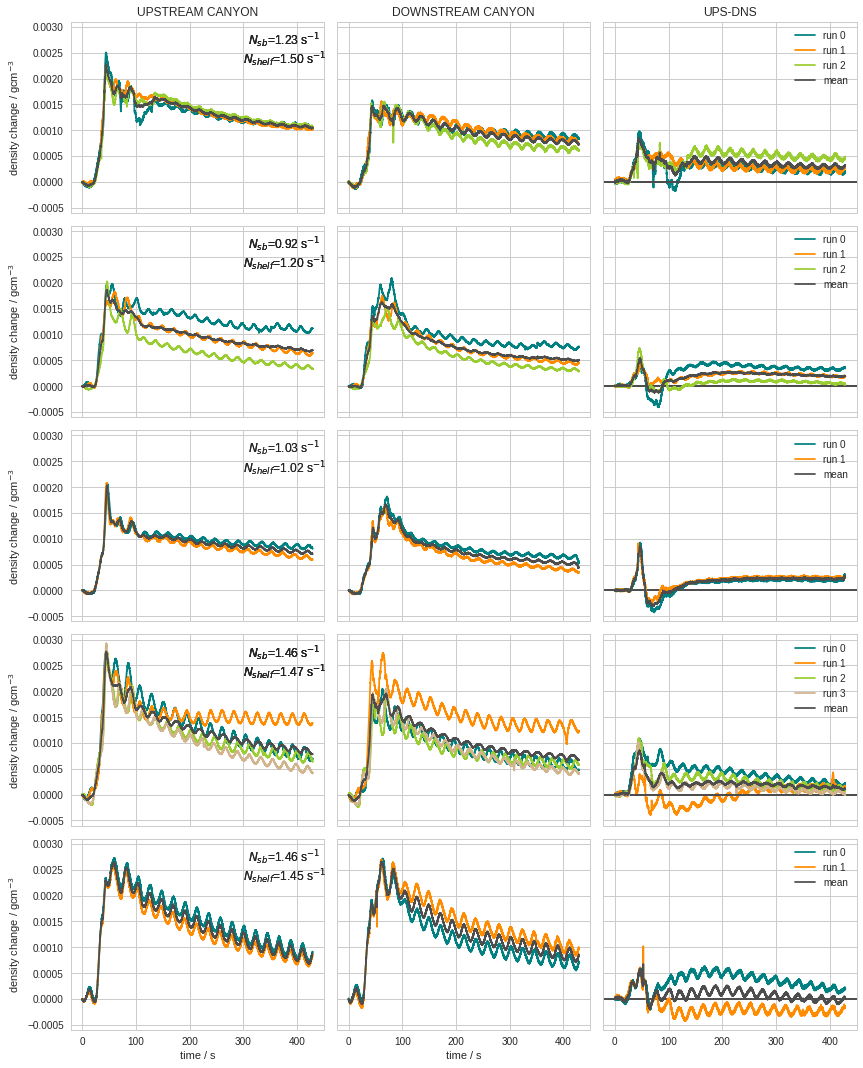

In [20]:
fig, ax = plt.subplots(exp_num, 3, figsize=(12,exp_num*3), sharey=True, sharex=True)

ax[0,0].set_title('UPSTREAM CANYON')
ax[0,1].set_title('DOWNSTREAM CANYON')
ax[0,2].set_title('UPS-DNS')

for exp, kk in zip(exp_dicts, range(exp_num)):
    avg1 = np.zeros_like(time)
    avg2 = np.zeros_like(time)
    avg3 = np.zeros_like(time)
    
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        time = mat['time']
        dens1 = ctools.densANK1_06Jul19(P1)
        dens2 = ctools.densANK2_06Jul19(P2)
        ax[kk,0].plot(time, dens1-dens1[0],'-',color=col, label='run %d' %ii)
        ax[kk,1].plot(time, dens2-dens2[0],'-',color=col, label='run %d' %ii)
        ax[kk,2].axhline(0, color='0.3')
        ax[kk,2].plot(time, (dens1-dens1[0])-(dens2-dens2[0]),'-',color=col, label='run %d' %ii)
        ax[kk,0].text(0.70,0.88,'$N_{sb}$=%1.2f s$^{-1}$' %exp["Nsb"], transform=ax[kk,0].transAxes)
        ax[kk,0].text(0.68,0.78,'$N_{shelf}$=%1.2f s$^{-1}$' %exp["Nshelf"], transform=ax[kk,0].transAxes)
        avg1 = avg1+(dens1-dens1[0])
        avg2 = avg2+(dens2-dens2[0])
        avg3 = avg3+((dens1-dens1[0])-(dens2-dens2[0]))
    
    ax[kk,0].plot(time, avg1/(len(exp['run_files'])),'-',color='0.3', label='mean')
    ax[kk,1].plot(time, avg2/(len(exp['run_files'])),'-',color='0.3', label='mean')
    ax[kk,2].plot(time, avg3/(len(exp['run_files'])),'-',color='0.3', label='mean')    
    ax[kk,0].set_ylabel('density change / gcm$^{-3}$')
    ax[kk,2].legend(bbox_to_anchor=(1,1))

ax[kk,0].set_xlabel('time / s')
ax[kk,1].set_xlabel('time / s')
plt.tight_layout()

### Comparison average runs

Using calibration May 2nd

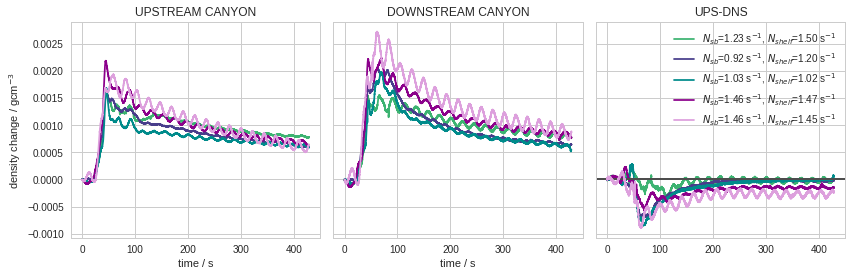

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey=True, sharex=True)

ax[0].set_title('UPSTREAM CANYON')
ax[1].set_title('DOWNSTREAM CANYON')
ax[2].set_title('UPS-DNS')

for exp, kk in zip(exp_dicts, range(exp_num)):
    avg1 = np.zeros_like(time)
    avg2 = np.zeros_like(time)
    avg3 = np.zeros_like(time)
    
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        time = mat['time']
        dens1 = ctools.densANK1_02May19(P1)
        dens2 = ctools.densANK2_02May19(P2)
        ax[2].axhline(0, color='0.3')
        label = '$N_{sb}$=%1.2f s$^{-1}$, $N_{shelf}$=%1.2f s$^{-1}$' %(exp["Nsb"],exp["Nshelf"])
        avg1 = avg1+(dens1-dens1[0])
        avg2 = avg2+(dens2-dens2[0])
        avg3 = avg3+((dens1-dens1[0])-(dens2-dens2[0]))
    
    ax[0].plot(time, avg1/(len(exp['run_files'])),'-',color=exp['color'], label=label)
    ax[1].plot(time, avg2/(len(exp['run_files'])),'-',color=exp["color"], label=label)
    ax[2].plot(time, avg3/(len(exp['run_files'])),'-',color=exp["color"], label=label)    
    ax[0].set_ylabel('density change / gcm$^{-3}$')
    ax[2].legend(bbox_to_anchor=(1,1))

ax[0].set_xlabel('time / s')
ax[1].set_xlabel('time / s')
plt.tight_layout()

Using calibration July 6th

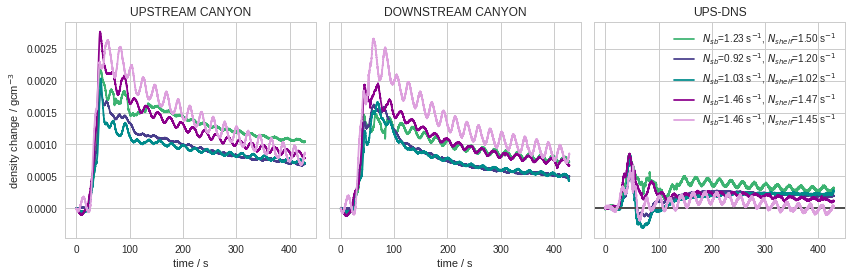

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey=True, sharex=True)

ax[0].set_title('UPSTREAM CANYON')
ax[1].set_title('DOWNSTREAM CANYON')
ax[2].set_title('UPS-DNS')

for exp, kk in zip(exp_dicts, range(exp_num)):
    avg1 = np.zeros_like(time)
    avg2 = np.zeros_like(time)
    avg3 = np.zeros_like(time)
    
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        time = mat['time']
        dens1 = ctools.densANK1_06Jul19(P1)
        dens2 = ctools.densANK2_06Jul19(P2)
        ax[2].axhline(0, color='0.3')
        label = '$N_{sb}$=%1.2f s$^{-1}$, $N_{shelf}$=%1.2f s$^{-1}$' %(exp["Nsb"],exp["Nshelf"])
        avg1 = avg1+(dens1-dens1[0])
        avg2 = avg2+(dens2-dens2[0])
        avg3 = avg3+((dens1-dens1[0])-(dens2-dens2[0]))
    
    ax[0].plot(time, avg1/(len(exp['run_files'])),'-',color=exp['color'], label=label)
    ax[1].plot(time, avg2/(len(exp['run_files'])),'-',color=exp["color"], label=label)
    ax[2].plot(time, avg3/(len(exp['run_files'])),'-',color=exp["color"], label=label)    
    ax[0].set_ylabel('density change / gcm$^{-3}$')
    ax[2].legend(bbox_to_anchor=(1,1))

ax[0].set_xlabel('time / s')
ax[1].set_xlabel('time / s')
plt.tight_layout()